# Plot Histogram for Normal and Sick X ray images

## Import and set paths

In [83]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from skimage import exposure


In [84]:
data_address = os.path.join(os.getcwd(),'..', 'Data')
image_address = os.path.join(data_address, 'Coronahack-Chest-XRay-Dataset', 'Coronahack-Chest-XRay-Dataset')
training_label = pd.read_csv(os.path.join(data_address, 'training_label.csv'))
testing_label = pd.read_csv(os.path.join(data_address, 'testing_label.csv'))


In [85]:
train_images_normal = [os.path.join(image_address, 'train', filename) for filename in training_label[training_label.Label == 'Normal'].X_ray_image_name.tolist()]
train_images_sick = [os.path.join(image_address, 'train', filename) for filename in training_label[training_label.Label == 'Pnemonia'].X_ray_image_name.tolist()]
test_images_normal = [os.path.join(image_address, 'test', filename) for filename in testing_label[testing_label.Label == 'Normal'].X_ray_image_name.tolist()]
test_images_sick = [os.path.join(image_address, 'test', filename) for filename in testing_label[testing_label.Label == 'Pnemonia'].X_ray_image_name.tolist()]


## Normal vs Sick

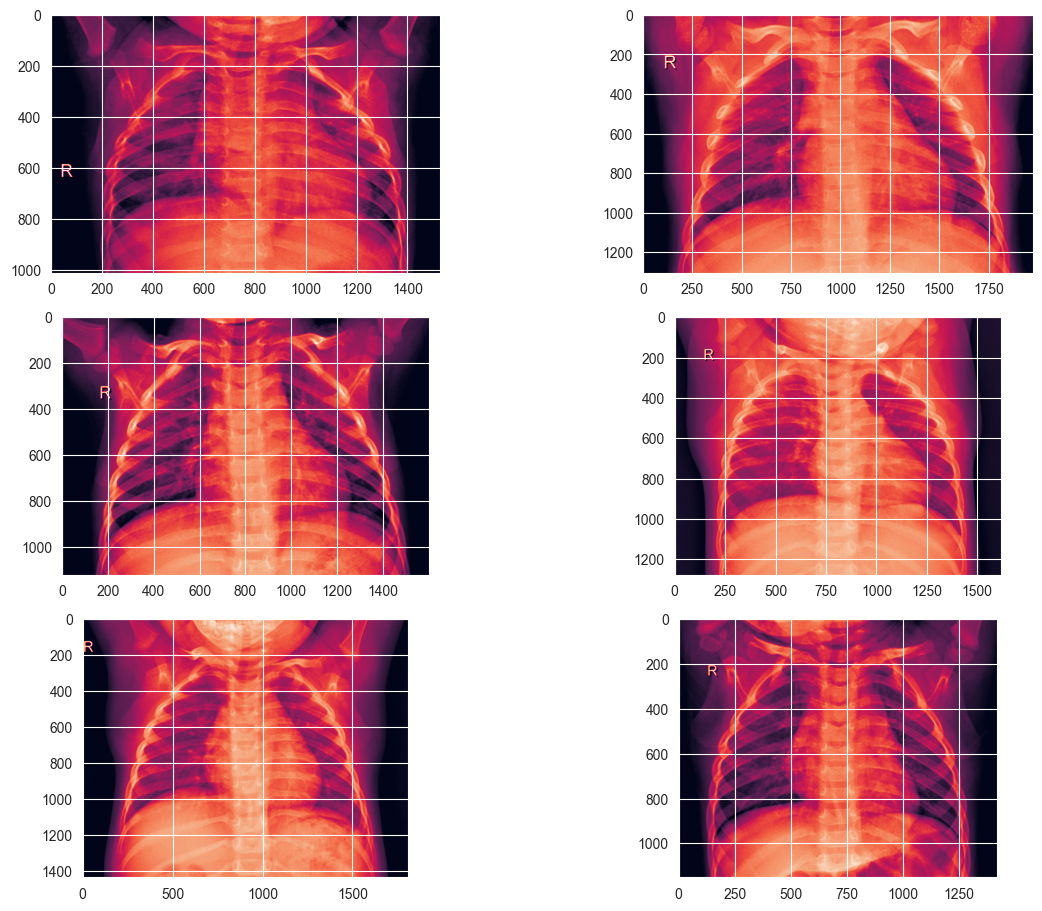

In [86]:
from PIL import Image
path_draw = train_images_normal[:6]
plt.figure(figsize = (12,12))
for i, v in enumerate(path_draw):
    try:
        image = Image.open(v)
        plt.subplot(4,2,i+1)
        plt.imshow(image)
    except:
        continue

plt.tight_layout()

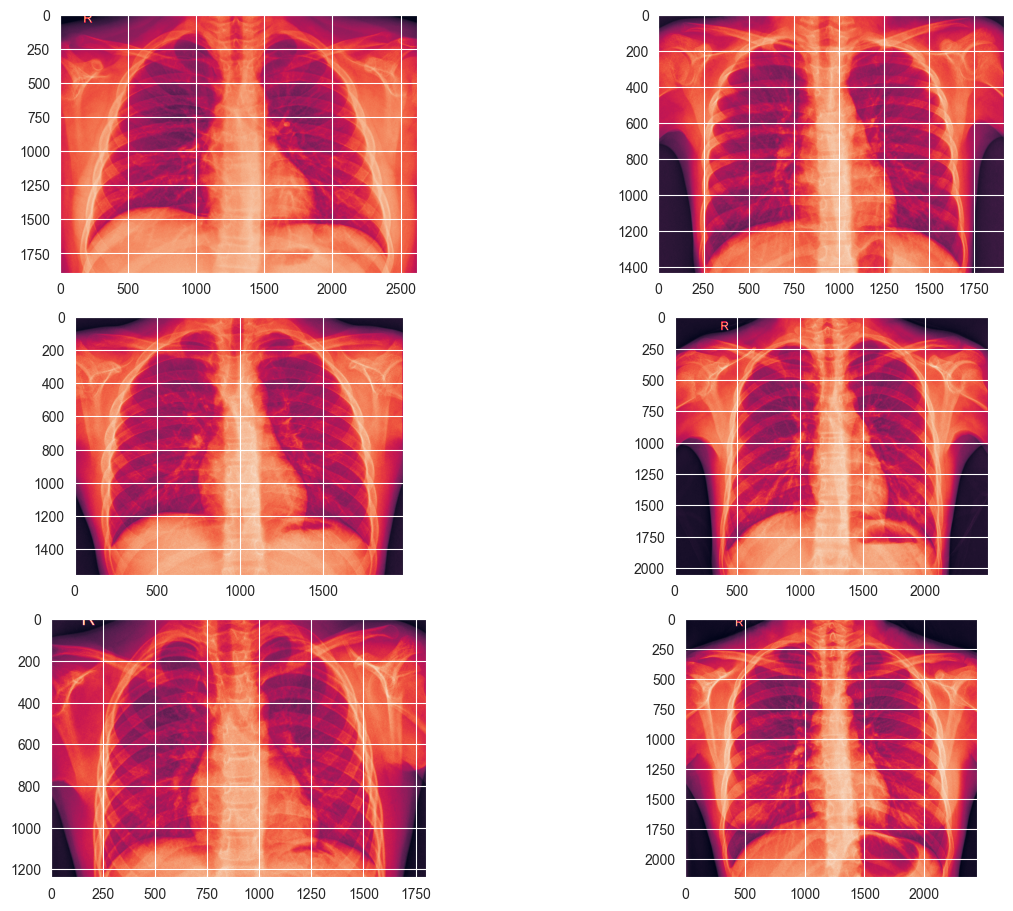

In [87]:
from PIL import Image
path_draw = test_images_normal[:6]

plt.figure(figsize = (12,12))
for i, v in enumerate(path_draw):
    try:
        image = Image.open(v)
        plt.subplot(4,2,i+1)
        plt.imshow(image)
    except:
        continue

plt.tight_layout()

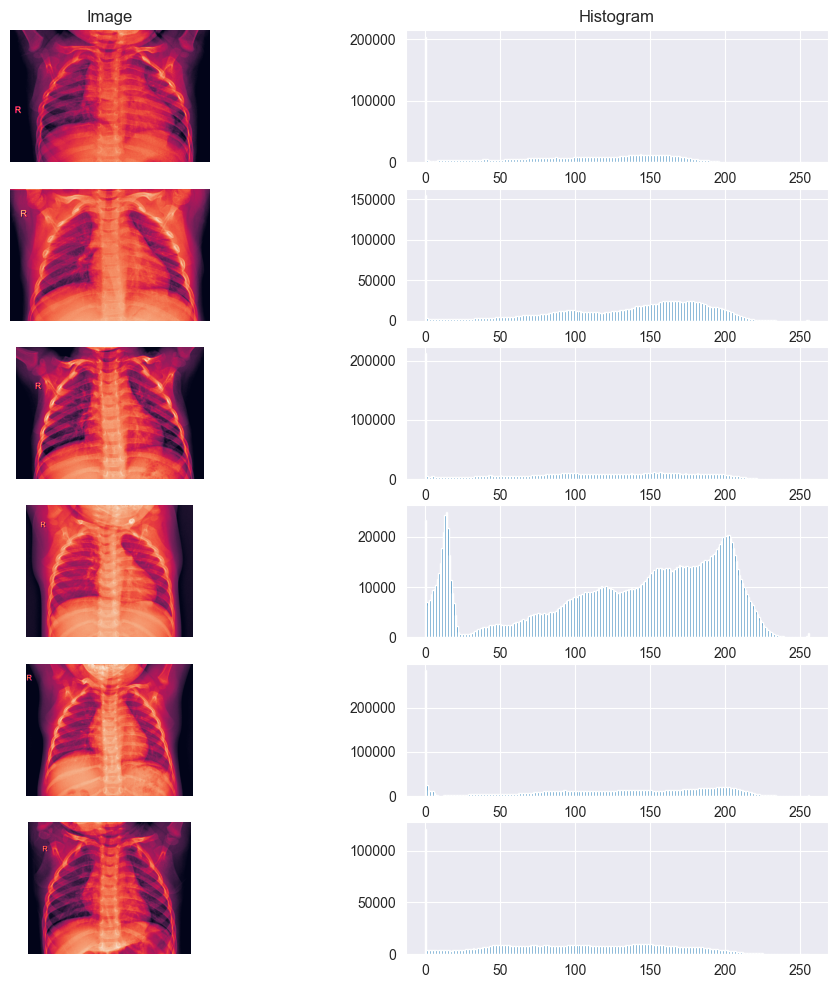

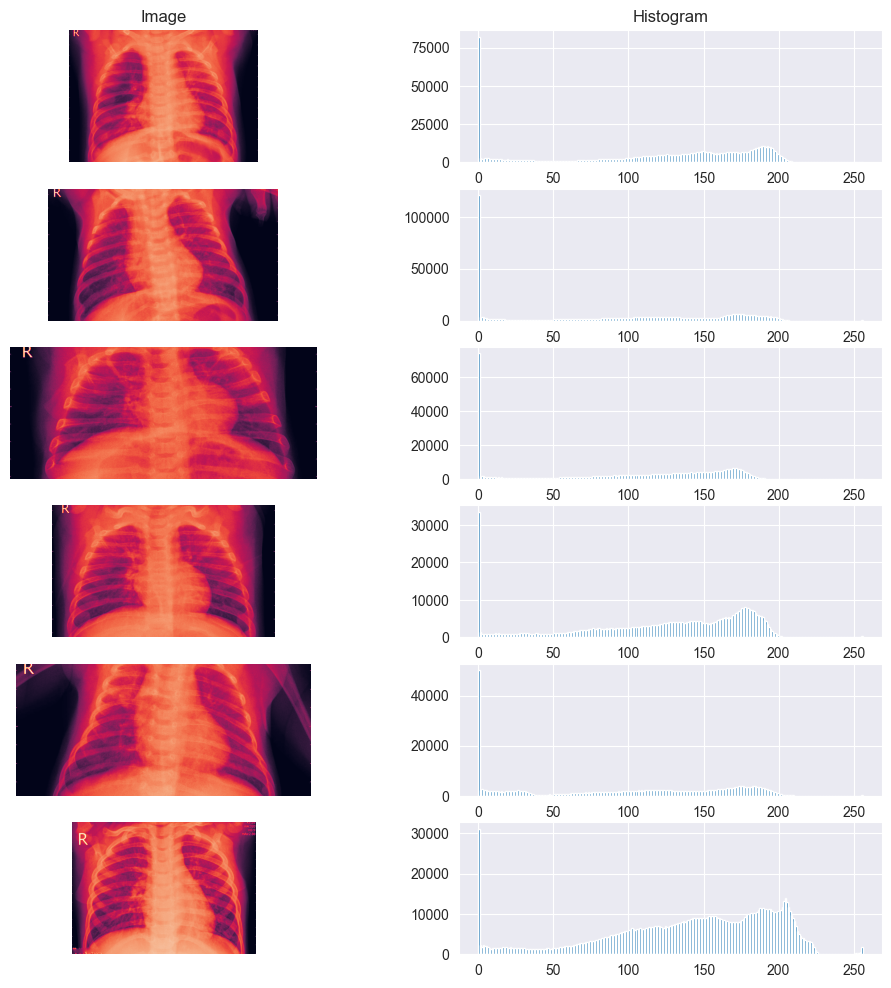

In [88]:
# Histogram analysis
def plot_graph_hist(path_draw, figsize = (12,12), title_left = 'Image', title_right = 'Histogram', mode = None):
    fig, ax = plt.subplots(len(path_draw), 2, figsize=figsize)
    for i, v in enumerate(path_draw):
        image = plt.imread(v)
        ax[i, 0].imshow(image)
        if mode == 'RGB':
            for col, channel in zip('rgb', np.rollaxis(image, axis=-1)):
                hist, bin_centers = exposure.histogram(channel)
                ax[i, 1].fill_between(bin_centers, hist, color=col, alpha=0.4)
        else:
            ax[i, 1].hist(image.ravel(), 256, [0, 256])
            ax[i, 0].axis('off')
        if i == 0:
            ax[i, 0].set_title(title_left)
            ax[i, 1].set_title(title_right)
    plt.show()
for paths in [train_images_normal[:6], test_images_sick[:6]]:
    plot_graph_hist(paths)

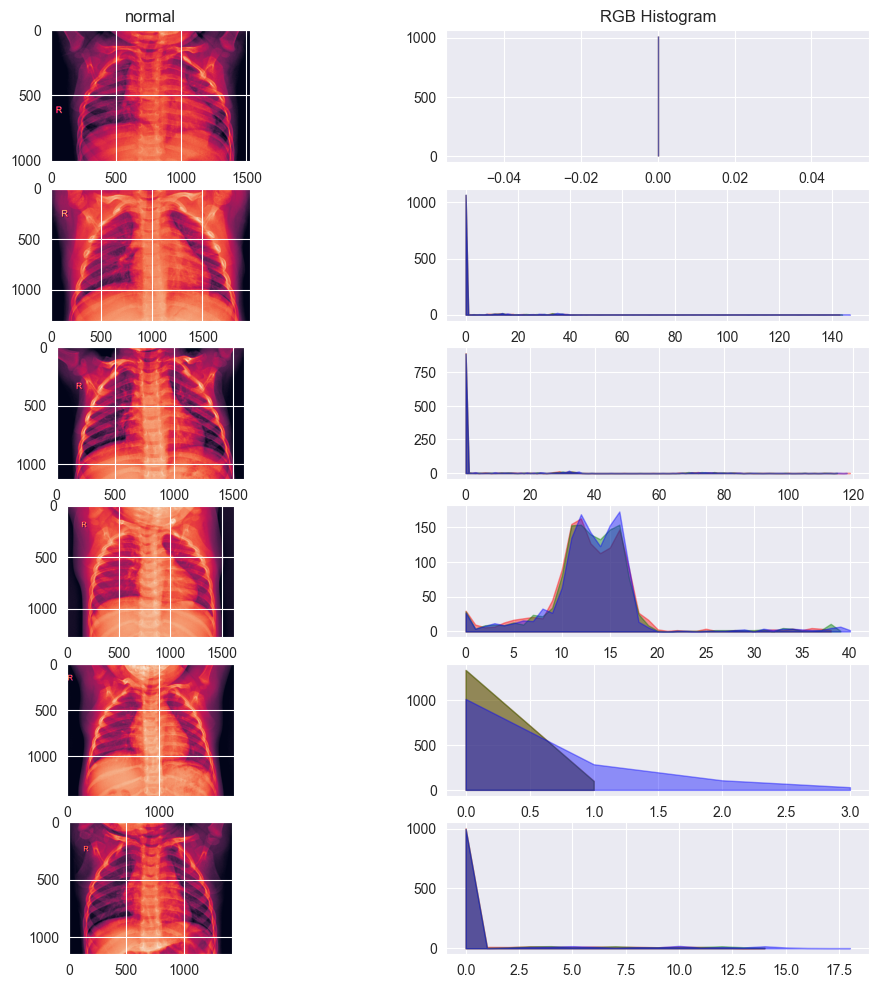

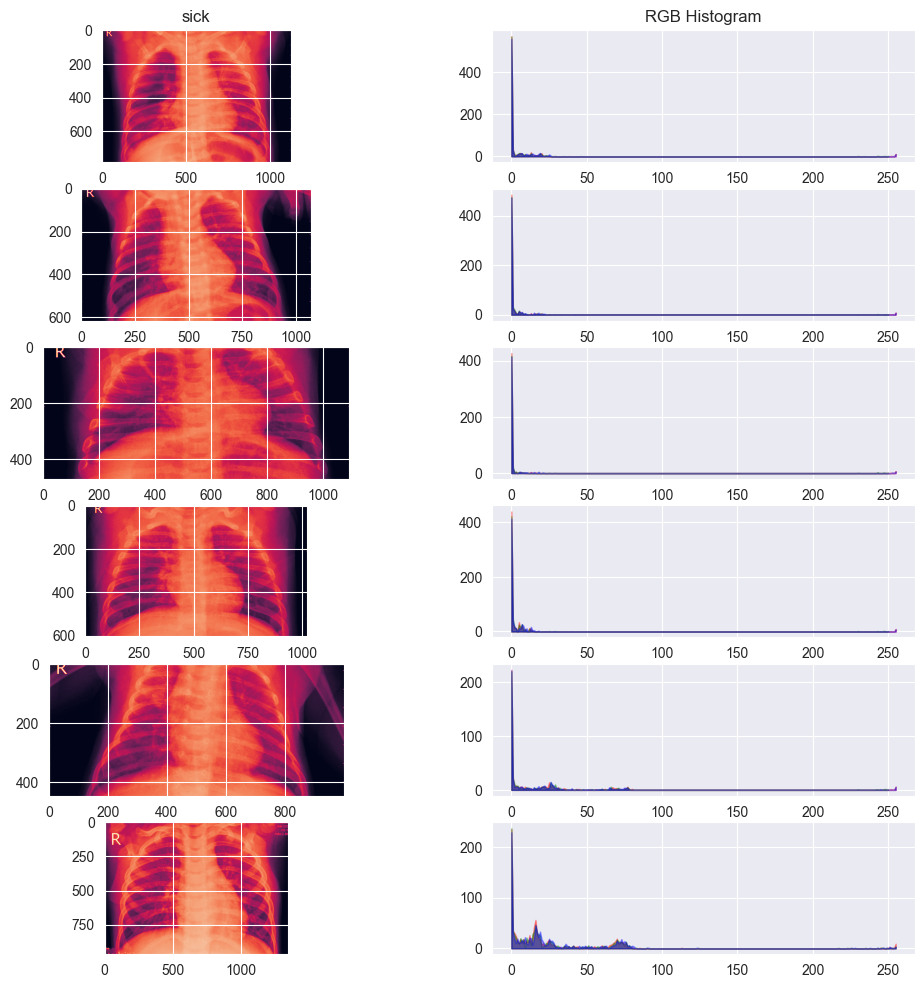

In [89]:
for paths, lebel in [(train_images_normal[:6],"normal"), (test_images_sick[:6], "sick")]:
    plot_graph_hist(paths, title_left = lebel, title_right = 'RGB Histogram', mode = 'RGB')